In [17]:
import matplotlib.pyplot as plt
import numpy as np

from superfv import EulerSolver, OutputLoader, plot_1d_slice
from superfv.initial_conditions import toro2
from teyssier import cons_to_prim, riemann, weno

In [18]:
T = 0.15
N = 100
gamma = 1.4
overwrite = False

base_path = "../../out/toro2/"

In [19]:
# compute exact solution
xana = ((np.arange(1024) + 0.5) / 1024)
wana = np.zeros([5, 1024, 1, 1])
for i in range(0, np.size(xana)):
    s = (xana[i] - 0.5) / 0.15
    d, v, p = riemann.exact_solution(s, [1, -2, 0.4], [1, 2, 0.4])
    wana[:, i, 0, 0] = [d, v, 0, 0, p]

In [20]:
common = dict(PAD={"rho": (0, None), "P": (0, None)})
musclhancock = dict(p=1, MUSCL=True, **common)
apriori = dict(ZS=True, lazy_primitives="adaptive", **common)
aposteriori = dict(
    MOOD=True,
    face_fallback=False,
    lazy_primitives="full",
    MUSCL_limiter="moncen",
    **common,
)
aposteriori1 = dict(cascade="muscl", max_MOOD_iters=1, **aposteriori)
aposteriori2 = dict(cascade="muscl1", max_MOOD_iters=2, **aposteriori)
aposteriori3 = dict(cascade="muscl1", max_MOOD_iters=3, **aposteriori)

configs = {
    "MUSCL-Hancock": dict(MUSCL_limiter="moncen", **musclhancock),
    "ZS3": dict(p=3, **apriori),
    "ZS7": dict(p=7, **apriori),
    "MM3/1rev/rtol_0": dict(p=3, NAD_rtol=0, **aposteriori1),
    "MM7/1rev/rtol_0": dict(p=7, NAD_rtol=0, **aposteriori1),
    "MM3/1rev/rtol_1e-5": dict(p=3, NAD_rtol=1e-5, **aposteriori1),
    "MM7/1rev/rtol_1e-5": dict(p=7, NAD_rtol=1e-5, **aposteriori1),
    "MM3/1rev/rtol_1e-3": dict(p=3, NAD_rtol=1e-3, **aposteriori1),
    "MM7/1rev/rtol_1e-3": dict(p=7, NAD_rtol=1e-3, **aposteriori1),
    "MM3/1rev/rtol_1e-2": dict(p=3, NAD_rtol=1e-2, **aposteriori1),
    "MM7/1rev/rtol_1e-2": dict(p=7, NAD_rtol=1e-2, **aposteriori1),
    "MM3/1rev/rtol_1e-1": dict(p=3, NAD_rtol=1e-1, **aposteriori1),
    "MM7/1rev/rtol_1e-1": dict(p=7, NAD_rtol=1e-1, **aposteriori1),
    "MM3/1rev/rtol_1e0": dict(p=3, NAD_rtol=1e0, **aposteriori1),
    "MM7/1rev/rtol_1e0": dict(p=7, NAD_rtol=1e0, **aposteriori1),
    "MM3/1rev/rtol_1e1": dict(p=3, NAD_rtol=1e1, **aposteriori1),
    "MM7/1rev/rtol_1e1": dict(p=7, NAD_rtol=1e1, **aposteriori1),
    "MM3/1rev/rtol_1e2": dict(p=3, NAD_rtol=1e2, **aposteriori1),
    "MM7/1rev/rtol_1e2": dict(p=7, NAD_rtol=1e2, **aposteriori1),
    "MM3/1rev/no_NAD": dict(p=3, NAD=False, SED=False, **aposteriori1),
    "MM7/1rev/no_NAD": dict(p=7, NAD=False, SED=False, **aposteriori1),
    "MM3/3revs/rtol_0": dict(p=3, NAD_rtol=0, **aposteriori3),
    "MM7/3revs/rtol_0": dict(p=7, NAD_rtol=0, **aposteriori3),
    "MM3/3revs/rtol_1e-5": dict(p=3, NAD_rtol=1e-5, **aposteriori3),
    "MM7/3revs/rtol_1e-5": dict(p=7, NAD_rtol=1e-5, **aposteriori3),
    "MM3/3revs/rtol_1e-2": dict(p=3, NAD_rtol=1e-2, **aposteriori3),
    "MM7/3revs/rtol_1e-2": dict(p=7, NAD_rtol=1e-2, **aposteriori3),
    "MM3/3revs/rtol_1e-1": dict(p=3, NAD_rtol=1e-1, **aposteriori3),
    "MM7/3revs/rtol_1e-1": dict(p=7, NAD_rtol=1e-1, **aposteriori3),
    "MM3/3revs/rtol_1e0": dict(p=3, NAD_rtol=1e0, **aposteriori3),
    "MM7/3revs/rtol_1e0": dict(p=7, NAD_rtol=1e0, **aposteriori3),
    "MM3/3revs/rtol_1e1": dict(p=3, NAD_rtol=1e1, **aposteriori3),
    "MM7/3revs/rtol_1e1": dict(p=7, NAD_rtol=1e1, **aposteriori3),
    "MM3/3revs/rtol_1e2": dict(p=3, NAD_rtol=1e2, **aposteriori3),
    "MM7/3revs/rtol_1e2": dict(p=7, NAD_rtol=1e2, **aposteriori3),
}

In [21]:
sims = {}
for name, config in configs.items():
    sim_path = f"{base_path}{name}"

    if not overwrite:
        try:
            sim = OutputLoader(sim_path)
            sims[name] = sim
            continue
        except FileNotFoundError:
            pass

        # try to read 'error.txt'
        try:
            with open(f"{sim_path}/error.txt", "r") as f:
                print(f"Skipping simulation {name} due to previous error.")
            continue
        except FileNotFoundError:
            pass

    print(f"Running simulation: {name}")
    sim = EulerSolver(
        ic=toro2,
        gamma=gamma,
        bcx="free",
        nx=N,
        **config,
    )

    try:
        sim.run(
            T,
            q_max=2,
            muscl_hancock=config.get("MUSCL", False),
            path=sim_path,
            allow_overshoot=True,
            overwrite=overwrite,
            max_steps=10000,
        )
    except Exception as e:
        print(f"Simulation {name} failed with error: {e}")
        with open(f"{sim_path}/error.txt", "w") as f:
            f.write(str(e))
        continue

    sims[name] = sim

Running simulation: MUSCL-Hancock
Step #52 @ t=1.51e-01 | dt=2.91e-03 | min(rho)=2.68e-02, min(P)=5.82e-03 | E_cons=2.06e+02 | (ran in 0.01s)
Running simulation: ZS3
Step #52 @ t=1.51e-01 | dt=2.91e-03 | min(rho)=2.71e-02, min(P)=3.73e-03 | E_cons=2.06e+02 | (ran in 0.06s)
Running simulation: ZS7
Step #52 @ t=1.51e-01 | dt=2.91e-03 | min(rho)=2.70e-02, min(P)=3.53e-03 | E_cons=2.06e+02 | (ran in 0.07s)
Running simulation: MM3/1rev/rtol_0
Step #52 @ t=1.51e-01 | dt=2.91e-03 | min(rho)=2.67e-02, min(P)=4.35e-03 | E_cons=2.06e+02 | (ran in 0.09s)
Running simulation: MM7/1rev/rtol_0
Step #52 @ t=1.51e-01 | dt=2.91e-03 | min(rho)=2.72e-02, min(P)=4.44e-03 | E_cons=2.06e+02 | (ran in 0.09s)
Running simulation: MM3/1rev/rtol_1e-5
Step #52 @ t=1.51e-01 | dt=2.91e-03 | min(rho)=2.67e-02, min(P)=4.35e-03 | E_cons=2.06e+02 | (ran in 0.09s)
Running simulation: MM7/1rev/rtol_1e-5
Step #52 @ t=1.51e-01 | dt=2.91e-03 | min(rho)=2.72e-02, min(P)=4.44e-03 | E_cons=2.06e+02 | (ran in 0.09s)
Running simu

In [22]:
def entropy(idx, mesh, w):
    return w[idx("P")] / w[idx("rho")]**gamma

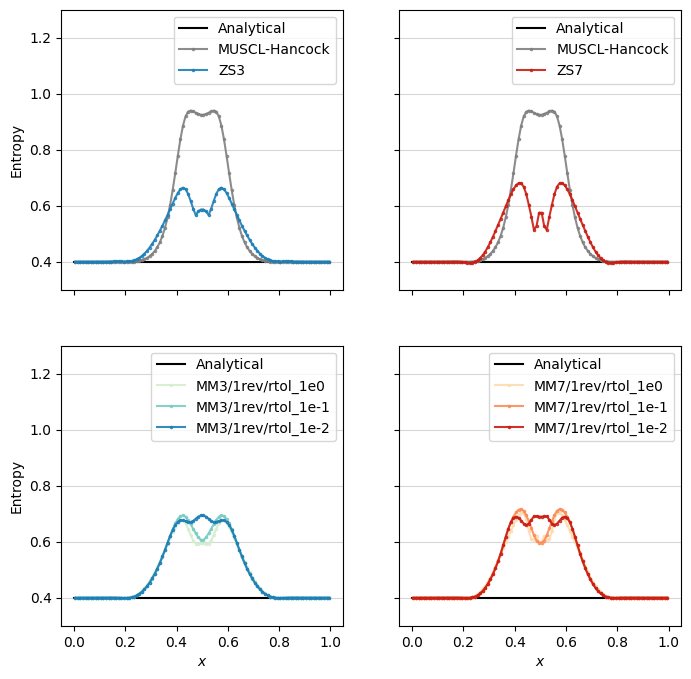

In [23]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 8))
axs[0, 0].set_ylabel("Entropy")
axs[1, 0].set_ylabel("Entropy")
axs[1, 0].set_xlabel(r"$x$")
axs[1, 1].set_xlabel(r"$x$")
axs[0, 0].set_ylim(0.3, 1.3)

idx = sims["MUSCL-Hancock"].variable_index_map

axs[0, 0].plot(xana, entropy(idx, None, wana)[:, 0, 0], color='k', label="Analytical")
axs[0, 1].plot(xana, entropy(idx, None, wana)[:, 0, 0], color='k', label="Analytical")
axs[1, 0].plot(xana, entropy(idx, None, wana)[:, 0, 0], color='k', label="Analytical")
axs[1, 1].plot(xana, entropy(idx, None, wana)[:, 0, 0], color='k', label="Analytical")

cmap1 = plt.get_cmap("GnBu")
cmap2 = plt.get_cmap("OrRd")
common_style = dict(alpha=0.9, linewidth=1.5, markersize=1.5, marker='o', mfc='none')

def plot(name, ax, style=dict()):
    plot_1d_slice(sims[name], ax, "w", multivar_func=entropy, label=name, **style, **common_style)

plot("MUSCL-Hancock", axs[0, 0], style=dict(color='grey'))
plot("ZS3", axs[0, 0], style=dict(color=cmap1(0.8)))

plot("MUSCL-Hancock", axs[0, 1], style=dict(color='grey'))
plot("ZS7", axs[0, 1], style=dict(color=cmap2(0.8)))

plot("MM3/1rev/rtol_1e0", axs[1, 0], style=dict(color=cmap1(0.2)))
plot("MM3/1rev/rtol_1e-1", axs[1, 0], style=dict(color=cmap1(0.5)))
plot("MM3/1rev/rtol_1e-2", axs[1, 0], style=dict(color=cmap1(0.8)))

plot("MM7/1rev/rtol_1e0", axs[1, 1], style=dict(color=cmap2(0.2)))
plot("MM7/1rev/rtol_1e-1", axs[1, 1], style=dict(color=cmap2(0.5)))
plot("MM7/1rev/rtol_1e-2", axs[1, 1], style=dict(color=cmap2(0.8)))

# horizontal grid lines
axs[0, 0].grid(axis='y', alpha=0.5)
axs[0, 1].grid(axis='y', alpha=0.5)
axs[1, 0].grid(axis='y', alpha=0.5)
axs[1, 1].grid(axis='y', alpha=0.5)

axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()

In [24]:
fig.savefig("toro2.pdf", bbox_inches='tight')